In [1]:
# import itertools
import os
import sys
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.io

from collections import defaultdict
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import re
import h5py
import napari
import tifffile as tiff
import seaborn as sns
import pickle

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
p_dir = (Path().cwd().parents[0]).absolute()

module_path = str(p_dir / "src")
 
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
data_dir = (Path().cwd().parents[0] / 'data').absolute()

df_imgs_path = data_dir /  'sun_PPI'  /'metadata' / 'imgs_reg.csv'
df_imgs = pd.read_csv(df_imgs_path)


In [5]:
df_imgs

,Cell,Condition,FOV,Path
0,HCC827,O,fixed,y:\coskun-lab\Thomas\23_PLA_revision\data\sun_...
1,HCC827,O,live,y:\coskun-lab\Thomas\23_PLA_revision\data\sun_...
2,HCC827,ctrl,fixed,y:\coskun-lab\Thomas\23_PLA_revision\data\sun_...
3,HCC827,ctrl,live,y:\coskun-lab\Thomas\23_PLA_revision\data\sun_...
4,HCC827,negct,fixed,y:\coskun-lab\Thomas\23_PLA_revision\data\sun_...
5,PC9,O,fixed,y:\coskun-lab\Thomas\23_PLA_revision\data\sun_...
6,PC9,O,live,y:\coskun-lab\Thomas\23_PLA_revision\data\sun_...
7,PC9,ctrl,fixed,y:\coskun-lab\Thomas\23_PLA_revision\data\sun_...
8,PC9,ctrl,live,y:\coskun-lab\Thomas\23_PLA_revision\data\sun_...
9,PC9,negct,fixed,y:\coskun-lab\Thomas\23_PLA_revision\data\sun_...


# QC segmentation

In [6]:
from skimage import morphology, measure
from skimage.segmentation import clear_border
from collections import defaultdict
   
def count_pixel_label_mask(regionmask, intensity_image):
    v,c = np.unique(intensity_image[regionmask], return_counts=True)
    return dict(zip(v,c))
    
# Quality control of mask
def qc_cyto(mask_cyto,  small_size=2000):
    '''
    Function to check if cell masks contain nuclei
    '''
    
    # Filter out small objects
    mask_cyto = morphology.remove_small_objects(mask_cyto,  min_size=small_size)
    
    return mask_cyto

In [7]:
# Read masks paths 
mask_dir = data_dir / 'sun_PPI' / 'imgs' / 'masks'
mask_filt_dir = data_dir / 'sun_PPI' / 'imgs' / 'masks_filtered'
mask_filt_dir.mkdir(parents=True, exist_ok=True)

masks_path = defaultdict(dict) 
for path in os.listdir(mask_dir):
    name = path.split('.')[0]
    if 'Nuclei' in name:
        masks_path[name[7:]]['nuclei'] = mask_dir / path
    else:
        masks_path[name]['cyto'] = mask_dir / path


In [8]:
masks_path

defaultdict(dict,
            {'HCC827_ctrl_fixed': {'cyto': WindowsPath('y:/coskun-lab/Thomas/23_PLA_revision/data/sun_PPI/imgs/masks/HCC827_ctrl_fixed.png')},
             'HCC827_ctrl_live': {'cyto': WindowsPath('y:/coskun-lab/Thomas/23_PLA_revision/data/sun_PPI/imgs/masks/HCC827_ctrl_live.png')},
             'HCC827_negct_fixed': {'cyto': WindowsPath('y:/coskun-lab/Thomas/23_PLA_revision/data/sun_PPI/imgs/masks/HCC827_negct_fixed.png')},
             'HCC827_O_fixed': {'cyto': WindowsPath('y:/coskun-lab/Thomas/23_PLA_revision/data/sun_PPI/imgs/masks/HCC827_O_fixed.png')},
             'HCC827_O_live': {'cyto': WindowsPath('y:/coskun-lab/Thomas/23_PLA_revision/data/sun_PPI/imgs/masks/HCC827_O_live.png')},
             'PC9_ctrl_fixed': {'cyto': WindowsPath('y:/coskun-lab/Thomas/23_PLA_revision/data/sun_PPI/imgs/masks/PC9_ctrl_fixed.png')},
             'PC9_ctrl_live': {'cyto': WindowsPath('y:/coskun-lab/Thomas/23_PLA_revision/data/sun_PPI/imgs/masks/PC9_ctrl_live.png')},
         

In [9]:
for row in df_imgs.itertuples():
    # Read image
    path = row.Path
    name = '_'.join(row[1:4])
    
    # Read masks
    mask_cyto_path = masks_path[name]['cyto']
    
    mask_cyto = skimage.io.imread(mask_cyto_path)
    cell = qc_cyto(mask_cyto)
    
    file_path =  mask_filt_dir / f'{name}.tif'
    tiff.imwrite(file_path, cell)

# PLA quantification

In [10]:
import PLA

PPI_save_path =  data_dir /   'sun_PPI'   / 'PPI'
PPI_save_path.mkdir(parents=True, exist_ok=True)

In [13]:
for row in df_imgs.itertuples():
    path = row.Path
    with h5py.File(path, 'r') as f:
        # imgs = f['cycle1'][:]
        markers = f['imgs'].attrs['Marker']
    print(markers)
    break

['Hoechst' 'TRAIL/DR5' 'Hoechst' 'Phalloidin']


In [33]:
RNAs = ['TRAIL/DR5']

for row in df_imgs.itertuples():
    # Read image
    path = row.Path
    pla_detect = PLA.PLA_detection(path, name='imgs', m='Marker')
    
    with h5py.File(path, 'r') as f:
        markers = f['imgs'].attrs['Marker']
        
    imgs_spots = []
    imgs_wths = []
    for RNA in RNAs: 
        if RNA in markers:
            img_spot, img_wth, _, img = pla_detect.detect_spot(RNA, thres=0.03, min_radius=2)
            imgs_spots.append(img_spot)
            imgs_wths.append(img_wth)
        
    # Save PPI dict
    name = '_'.join(row[1:4]) +'.pkl'
    pla_detect.save_pickle(PPI_save_path / name)


Reading image TRAIL/DR5
Processing image TRAIL/DR5
(array([0, 1], dtype=uint8), array([3830841,  123425], dtype=int64))
Reading image TRAIL/DR5
Processing image TRAIL/DR5
(array([0, 1], dtype=uint8), array([4081656,     180], dtype=int64))
Reading image TRAIL/DR5
Processing image TRAIL/DR5
(array([0, 1], dtype=uint8), array([3861127,  100043], dtype=int64))
Reading image TRAIL/DR5
Processing image TRAIL/DR5
(array([0, 1], dtype=uint8), array([3974533,    1021], dtype=int64))
Reading image TRAIL/DR5
Processing image TRAIL/DR5
(array([0, 1], dtype=uint8), array([3976887,    3829], dtype=int64))
Reading image TRAIL/DR5
Processing image TRAIL/DR5
(array([0, 1], dtype=uint8), array([3814707,  147618], dtype=int64))
Reading image TRAIL/DR5
Processing image TRAIL/DR5
(array([0, 1], dtype=uint8), array([3944531,    8601], dtype=int64))
Reading image TRAIL/DR5
Processing image TRAIL/DR5
(array([0, 1], dtype=uint8), array([3825178,  158430], dtype=int64))
Reading image TRAIL/DR5
Processing image

In [21]:
# import napari

# viewer = napari.view_image(np.stack(imgs_wths))
# viewer.add_image(np.stack(img))
# viewer.add_image(np.stack(imgs_spots), contrast_limits=[0,1], blending='additive')

# Extract per cell PPI count

In [34]:
import pickle 
from sklearn.neighbors import NearestNeighbors
import scipy 

def read_PPI(path):
    with open(path, 'rb') as file:
        PPI_dict = pickle.load(file)

    return PPI_dict

def create_PPI_df(PPI_labels, PPI_loc, name, cyto=True):
    if cyto:
        columns_name = ['Cyto', 'x', 'y']
    else:
        columns_name = ['Nuclei', 'x', 'y']
    df = pd.DataFrame(np.hstack([PPI_labels[:,np.newaxis], PPI_loc]), 
                      columns=columns_name)
    df['PPI'] = name
    return df

In [35]:
mask_filt_dir = data_dir /  'sun_PPI'   / 'imgs' / 'masks_filtered'
PPI_save_path =  data_dir /  'sun_PPI'  / 'PPI'

masks_path = defaultdict(dict) 
for path in os.listdir(mask_filt_dir):
    name = path.split('.')[0]
    masks_path[name] = mask_filt_dir / path
    

In [36]:
masks_path

defaultdict(dict,
            {'HCC827_ctrl_fixed': WindowsPath('y:/coskun-lab/Thomas/23_PLA_revision/data/sun_PPI/imgs/masks_filtered/HCC827_ctrl_fixed.tif'),
             'HCC827_ctrl_live': WindowsPath('y:/coskun-lab/Thomas/23_PLA_revision/data/sun_PPI/imgs/masks_filtered/HCC827_ctrl_live.tif'),
             'HCC827_negct_fixed': WindowsPath('y:/coskun-lab/Thomas/23_PLA_revision/data/sun_PPI/imgs/masks_filtered/HCC827_negct_fixed.tif'),
             'HCC827_O_fixed': WindowsPath('y:/coskun-lab/Thomas/23_PLA_revision/data/sun_PPI/imgs/masks_filtered/HCC827_O_fixed.tif'),
             'HCC827_O_live': WindowsPath('y:/coskun-lab/Thomas/23_PLA_revision/data/sun_PPI/imgs/masks_filtered/HCC827_O_live.tif'),
             'PC9_ctrl_fixed': WindowsPath('y:/coskun-lab/Thomas/23_PLA_revision/data/sun_PPI/imgs/masks_filtered/PC9_ctrl_fixed.tif'),
             'PC9_ctrl_live': WindowsPath('y:/coskun-lab/Thomas/23_PLA_revision/data/sun_PPI/imgs/masks_filtered/PC9_ctrl_live.tif'),
             'PC

In [37]:
for row in df_imgs.itertuples():
    name = '_'.join(row[1:4])
    
    # Read masks
    mask_cyto_path = masks_path[name]
    
    mask_cyto = skimage.io.imread(mask_cyto_path)

    # Read PPi
    PPI_dict = read_PPI(PPI_save_path / f'{name}.pkl')
    df_PPIs = []
    for k in PPI_dict.keys():
        PPI_loc = PPI_dict[k][:, 1:3].astype(np.uint32)
        
       # Cyto
        PPI_labels = mask_cyto[PPI_loc[:,0], PPI_loc[:,1]]
        df_PPI = create_PPI_df(PPI_labels, PPI_loc, k)
        df_PPIs.append(df_PPI)

    df_PPI = pd.concat(df_PPIs)
    df_PPI['Cell'] = row.Cell
    df_PPI['Condition'] = row.Condition
    df_PPI['FOV'] = row.FOV

    # Save dataframe
    path = PPI_save_path / f'{name}.csv'
    df_PPI.to_csv(path, index=False)

# Quantification

In [6]:
# Read PPI
PPI_save_path =  data_dir / 'sun_PPI' / 'PPI'

dfs = []
for path in os.listdir(PPI_save_path):
    if 'csv' in path:
        df = pd.read_csv(PPI_save_path / path)
        dfs.append(df)

df = pd.concat(dfs)

In [7]:
# Get nuclei and cell count
g = df.groupby(['Cell', 'Condition', 'FOV', 'PPI', 'Cyto']).size()
df_cell = pd.DataFrame({'Count Cyto': g}).reset_index()
df_cell = df_cell[df_cell.Cyto != 0]
df_cell.columns = ['Cell', 'Condition', 'FOV', 'PPI', 'Id', 'Count']
df_cell = (df_cell.pivot_table(values='Count', columns='PPI', index=['Cell','Condition', 'FOV','Id'])
.fillna(0)
.reset_index()
.melt(id_vars=['Cell', 'Condition', 'FOV','Id'], value_name='Count', var_name='PPI')
)


In [8]:
# Describe statistics
df_cell.groupby(['Cell', 'Condition', 'FOV', 'PPI'])['Count'].describe()

count       mean        std   min   25%  \
Cell   Condition FOV   PPI                                                  
HCC827 O         fixed TRAIL/DR5  339.0  10.342183   9.922228   1.0   3.0   
       ctrl      fixed TRAIL/DR5  227.0  13.810573  10.717791   1.0   4.0   
                 live  TRAIL/DR5    1.0  10.000000        NaN  10.0  10.0   
       negct     fixed TRAIL/DR5   73.0   1.465753   0.834702   1.0   1.0   
PC9    O         fixed TRAIL/DR5  187.0  22.032086  10.542746   1.0  14.0   
                 live  TRAIL/DR5   57.0   3.298246   5.716408   1.0   1.0   
       ctrl      fixed TRAIL/DR5  144.0  29.729167  14.051961   1.0  21.0   
                 live  TRAIL/DR5   33.0   3.090909   4.495579   1.0   1.0   
       negct     fixed TRAIL/DR5   62.0   1.209677   0.630823   1.0   1.0   

                                   50%    75%   max  
Cell   Condition FOV   PPI                           
HCC827 O         fixed TRAIL/DR5   7.0  15.00  58.0  
       ctrl      fixed TRAIL/DR5  12.0  21.00  54.0  
                 live  TRAIL/DR5  10.0  10.00  10.0  
       negct     fixed TRAIL/DR5   1.0   2.00   4.0  
PC9    O         fixed TRAIL/DR5  21.0  28.00  60.0  
                 live  TRAIL/DR5   1.0   2.00  29.0  
       ctrl      fixed TRAIL/DR5  28.0  37.25  67.0  
                 live  TRAIL/DR5   1.0   2.00  20.0  
       negct     fixed TRAIL/DR5   1.0   1.00   5.0

# Comparison between condition

In [9]:
from statannotations.Annotator import Annotator

def plot(plotting, figsize=(15,7), y_title='Count PPI per cell'):
    c1, c2 = plotting['data'][plotting['hue']].unique()
    pairs = [((e, c1), (e, c2)) for e in plotting['data'][plotting['x']].unique()]

    with sns.plotting_context('talk', font_scale=1.5):
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.boxplot(**plotting, showfliers=False, ax=ax)
        # ax = sns.swarmplot(**plotting, ax=ax, dodge=True)
        annot = Annotator(ax, pairs, **plotting)
        annot.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose=0)
        result = annot.apply_test().annotate()
        ax.set_ylabel(y_title, fontsize=40)
        plt.xticks(rotation=30, ha='right')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

In [10]:
# Boxplot per cell
plotting = {
    "data": df_cell[(df_cell.Cell == 'HCC827') & (df_cell.FOV == 'fixed')],
    "x": "PPI",
    "y": "Count",
    "hue": "Condition"
}


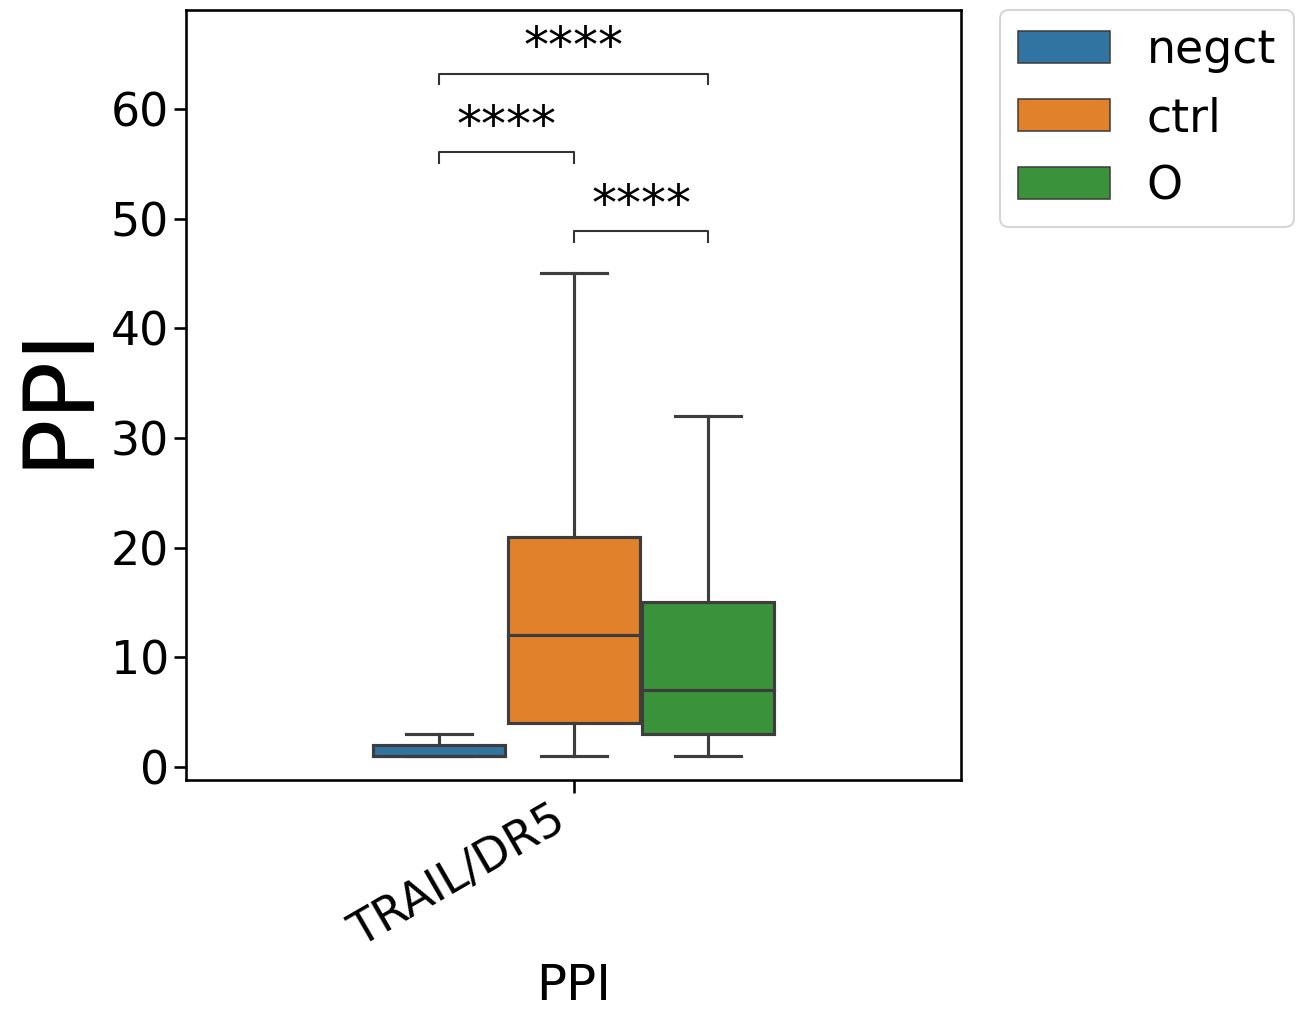

In [14]:
pairs = [((e, 'O'), (e, 'ctrl')) for e in plotting['data'][plotting['x']].unique()]
pairs +=  [((e, 'O'), (e, 'negct')) for e in plotting['data'][plotting['x']].unique()]
pairs +=  [((e, 'ctrl'), (e, 'negct')) for e in plotting['data'][plotting['x']].unique()]

with sns.plotting_context('talk', font_scale=2):
    fig, ax = plt.subplots(figsize=(10,10))
    ax = sns.boxplot(**plotting, showfliers=False, ax=ax, hue_order=['negct', 'ctrl', 'O'])
    annot = Annotator(ax, pairs, hue_order=['negct', 'ctrl', 'O'], **plotting)
    annot.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=0)
    result = annot.apply_test().annotate()
    ax.set_ylabel('PPI', fontsize=70)
    plt.xticks(rotation=30, ha='right')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

In [15]:
# Boxplot per cell
plotting = {
    "data": df_cell[(df_cell.Cell == 'PC9') & (df_cell.FOV == 'fixed')],
    "x": "PPI",
    "y": "Count",
    "hue": "Condition"
}


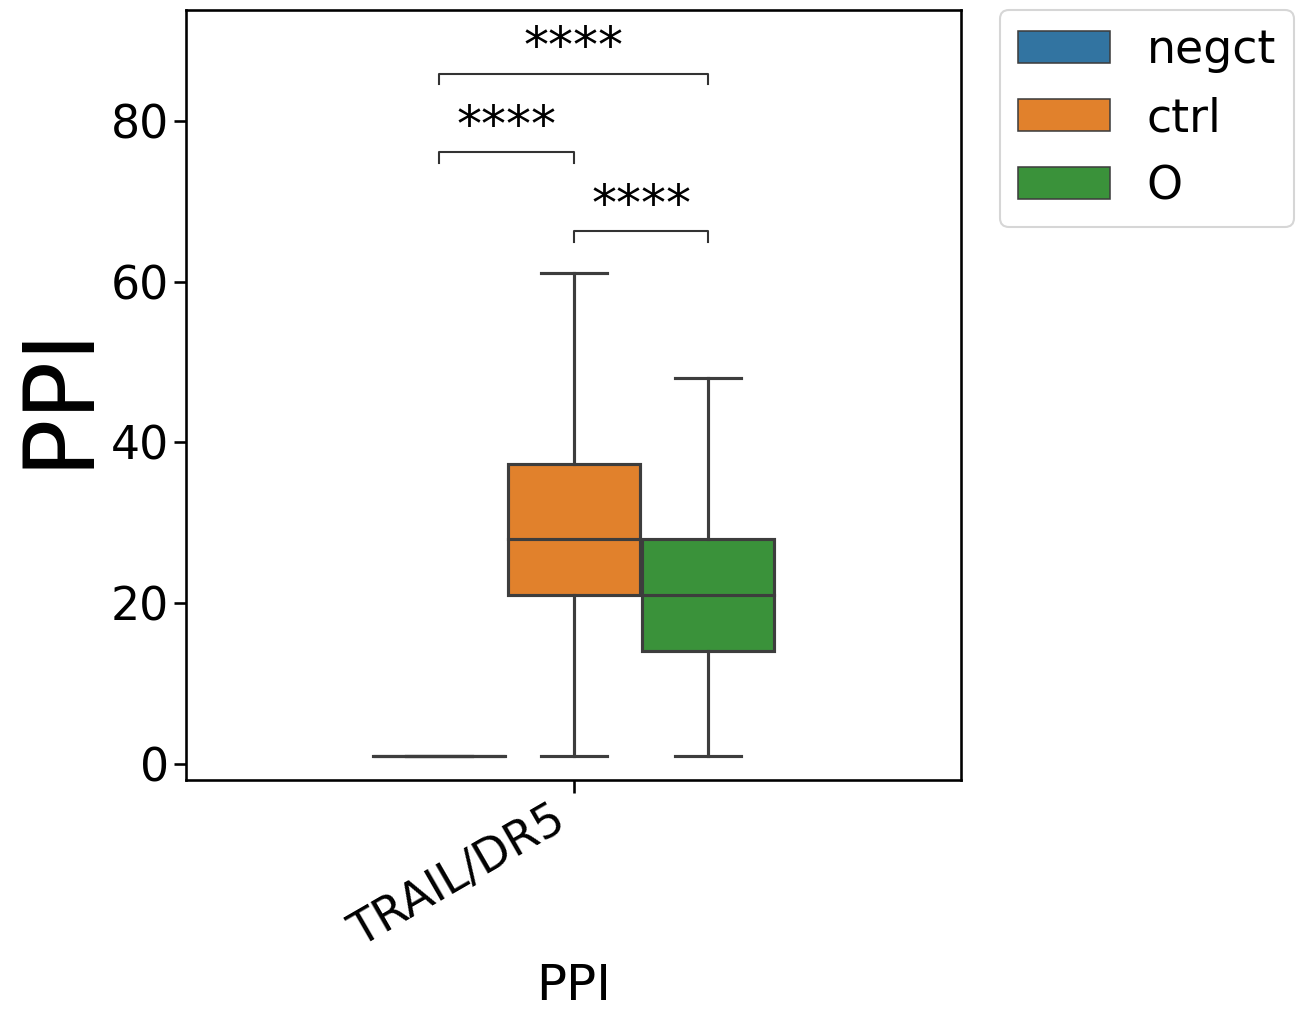

In [16]:
pairs = [((e, 'O'), (e, 'ctrl')) for e in plotting['data'][plotting['x']].unique()]
pairs +=  [((e, 'O'), (e, 'negct')) for e in plotting['data'][plotting['x']].unique()]
pairs +=  [((e, 'ctrl'), (e, 'negct')) for e in plotting['data'][plotting['x']].unique()]

with sns.plotting_context('talk', font_scale=2):
    fig, ax = plt.subplots(figsize=(10,10))
    ax = sns.boxplot(**plotting, showfliers=False, ax=ax, hue_order=['negct', 'ctrl', 'O'])
    annot = Annotator(ax, pairs, hue_order=['negct', 'ctrl', 'O'], **plotting)
    annot.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=0)
    result = annot.apply_test().annotate()
    ax.set_ylabel('PPI', fontsize=70)
    plt.xticks(rotation=30, ha='right')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

In [17]:
# Boxplot per cell
plotting = {
    "data": df_cell[(df_cell.Cell == 'PC9') & (df_cell.FOV == 'live')],
    "x": "PPI",
    "y": "Count",
    "hue": "Condition"
}


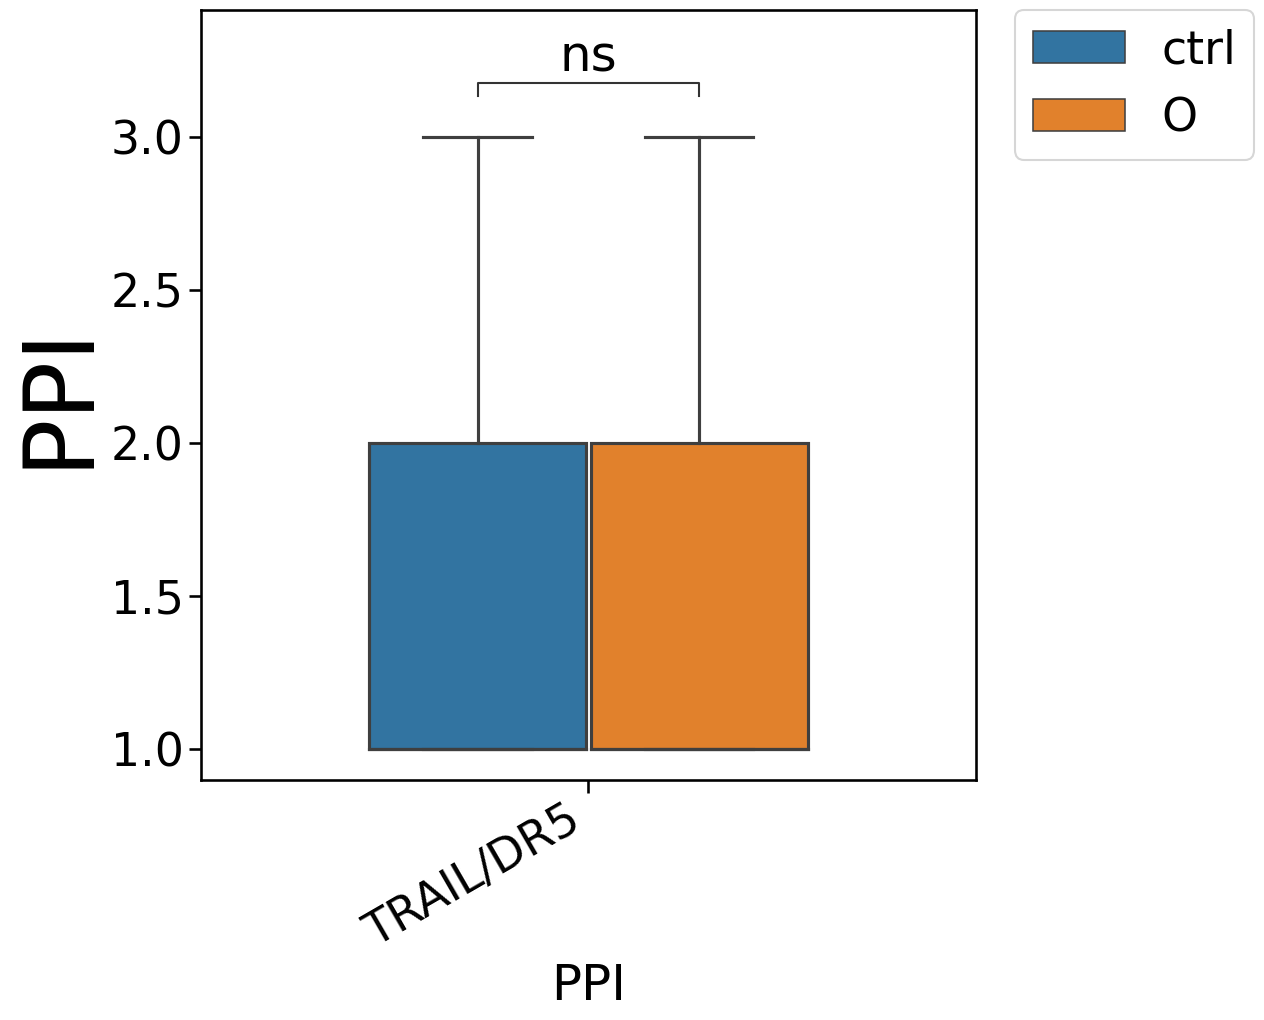

In [19]:
pairs = [((e, 'O'), (e, 'ctrl')) for e in plotting['data'][plotting['x']].unique()]

with sns.plotting_context('talk', font_scale=2):
    fig, ax = plt.subplots(figsize=(10,10))
    ax = sns.boxplot(**plotting, showfliers=False, ax=ax, hue_order=['ctrl', 'O'])
    annot = Annotator(ax, pairs, hue_order=['ctrl', 'O'], **plotting)
    annot.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=0)
    result = annot.apply_test().annotate()
    ax.set_ylabel('PPI', fontsize=70)
    plt.xticks(rotation=30, ha='right')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)